In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from os import path
import seaborn as sns
from matplotlib import gridspec as gs

from compton import create_observable_set, proton_pol_vec_std, proton_pol_vec_mean, neutron_pol_vec_std
from compton import proton_pol_vec_trans_std, proton_pol_vec_trans_mean
from compton import plot_subsets, compute_all_1pt_utilities, compute_max_utilities
from compton import convert_max_utilities_to_dataframe, convert_max_utilities_to_flat_dataframe

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

In [3]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [4]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
observables_unique = df['observable'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [5]:
observables_unique

array(['crosssection', '1X', '1Z', '2X', '2Z', '3', 'Y', '3Y', '3Yp',
       '1Xp', '1Zp', '2Xp', '2Zp'], dtype=object)

In [6]:
observables_unique[0] = 'dsg'

In [7]:
from sklearn.utils.extmath import cartesian
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

In [8]:
df[['omegalab [MeV]', 'thetalab [deg]']]

,omegalab [MeV],thetalab [deg]
0,5.0,1
1,5.0,1
2,5.0,5
3,5.0,5
4,5.0,10
...,...,...
284747,340.0,170
284748,340.0,175
284749,340.0,175
284750,340.0,180


In [9]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

We must make the transformation
\begin{align*}
\vec{\xi} \to \vec{\xi}' \equiv P \vec{\xi}
\end{align*}
that is
\begin{align*}
\begin{bmatrix}
\alpha + \beta \\
\alpha - \beta \\
\gamma_0 \\
\gamma_\pi \\
\gamma_{E-} \\
\gamma_{M-}
\end{bmatrix}
\equiv
\begin{bmatrix}
    1 &  1 &  0 &  0 &  0 &  0 \\
    1 & -1 &  0 &  0 &  0 &  0 \\
    0 &  0 & -1 & -1 & -1 & -1 \\
    0 &  0 & -1 &  1 & -1 &  1 \\
    0 &  0 &  1 &  0 & -1 &  0 \\
    0 &  0 &  0 &  1 &  0 & -1
\end{bmatrix}
\begin{bmatrix}
\alpha \\ \beta \\ \gamma_{E1E1} \\ \gamma_{M1M1} \\ \gamma_{E1M2} \\ \gamma_{M1E2}
\end{bmatrix}
\end{align*}
This is not an orthogonal transformation so we should not expect that the utility function will be invariant under this change of basis.

In [10]:
P = np.array([
    [1,  1,  0,  0,  0,  0],
    [1, -1,  0,  0,  0,  0],
    [0,  0, -1, -1, -1, -1],
    [0,  0, -1,  1, -1,  1],
    [0,  0,  1,  0, -1,  0],
    [0,  0,  0,  1,  0, -1]
])
P_inv = np.linalg.inv(P)

In [11]:
from itertools import combinations, product

data_combs = np.asarray(list(combinations(range(len(X)), 1)))

In [12]:
X_mask = (X[:, 0] == 15) & np.isin(X[:, 1], [15, 20, 25])
print(X_mask, '\n', X[X_mask])

[False False False ... False False False] 
 [[15. 15.]
 [15. 20.]
 [15. 25.]]


In [13]:
np.where(X_mask)

(array([77, 78, 79]),)

In [14]:
data_combs

array([[   0],
       [   1],
       [   2],
       ...,
       [2735],
       [2736],
       [2737]])

## Checking if the utility is invariant under change of polarizations

hint: it is not. no wait, it is!

In [15]:
cov_p_proton = np.diag(proton_pol_vec_std)
cov_p_proton_mapped = P @ cov_p_proton @ P.T

cov_p_neutron = np.diag(neutron_pol_vec_std)
cov_p_neutron_mapped = P @ cov_p_neutron @ P.T

In [16]:
compton_obs = create_observable_set(df=df, cov_exp=sd_exp**2, cov_p_proton=cov_p_proton, cov_p_neutron=cov_p_neutron)
compton_obs_mapped = create_observable_set(
    df=df, cov_exp=sd_exp**2, p_transform=P,
    cov_p_proton=cov_p_proton_mapped, cov_p_neutron=cov_p_neutron_mapped
)

In [17]:
np.linalg.det(cov_p_proton)

0.11240901846048648

In [18]:
np.linalg.det(cov_p_proton_mapped)

28.776708725884532

In [19]:
utils_no_trans = compute_all_1pt_utilities(compton_obs)

In [20]:
utils_with_trans = compute_all_1pt_utilities(compton_obs_mapped)

In [21]:
utils_no_trans['proton', '1X', 'all']

array([0.        , 0.        , 0.        , ..., 0.00833911, 0.00215698,
       0.        ])

In [22]:
utils_with_trans['proton', '1X', 'all']

array([0.        , 0.        , 0.        , ..., 0.00833911, 0.00215698,
       0.        ])

In [23]:
np.allclose(utils_no_trans['proton', '1X', 'all'], utils_with_trans['proton', '1X', 'all'])

True

In [24]:
np.allclose(utils_no_trans['neutron', '1X', 'all'], utils_with_trans['neutron', '1X', 'all'])

True

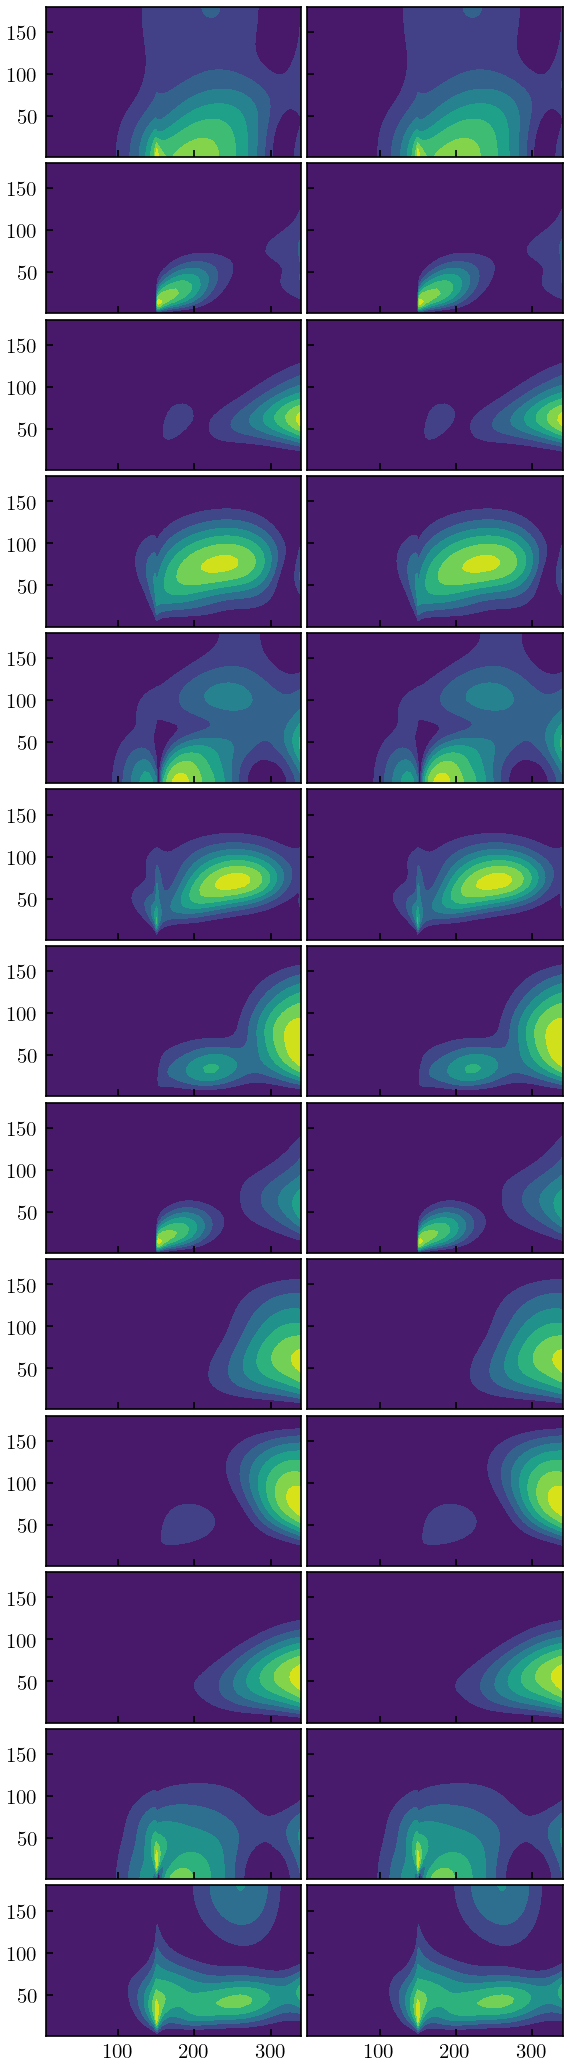

In [25]:
fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 14), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton']):
        ax = axes[i, j]
        order_i = 4
#         compton_i = compton_obs[obs_i, nucleon_j, order_i, 'linear']
#         compton_mapped_i = compton_obs_mapped[obs_i, nucleon_j, order_i, 'linear']

#         util_i = np.zeros(data_combs.shape, dtype=float)
#         util_i_mapped = np.zeros(data_combs.shape, dtype=float)
#         for k, idx_k in enumerate(data_combs):
#             util_i[k] = compton_i.utility_linear(idx_k)
#             util_i_mapped[k] = compton_mapped_i.utility_linear(idx_k)
        util_i = utils_no_trans[nucleon_j, obs_i, 'all']
        util_i_mapped = utils_with_trans[nucleon_j, obs_i, 'all']

        axes[i, 0].contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        axes[i, 1].contourf(omega_lab_unique, degrees_lab_unique, util_i_mapped.reshape(n_omega, n_angle).T)
        axes[i, 0].tick_params(direction='in')
        axes[i, 1].tick_params(direction='in')
fig.tight_layout(h_pad=0.3, w_pad=0.3)

## Check subsets of polarizabilities

In [26]:
subset_names = ['all', r'$\alpha+\beta$', r'$\alpha-\beta$', r'$\gamma_i$']
subset_idxs = [
    [0, 1, 2, 3, 4, 5],
    [0],
    [1],
    [2, 3, 4, 5],
]
savenames = [
    'all',
    'amb',
    'apb',
    'gammas'
]
# subsets = {'all': [0, 1, 2, 3, 4, 5], r'$\alpha+\beta$': [0], r'$\alpha-\beta$': [1], r'$\gamma_i$s': [2, 3, 4, 5]}
subsets = {name: idx for name, idx in zip(subset_names, subset_idxs)}
subset_savenames = {name: savename for name, savename in zip(subset_names, savenames)}

nucleons = ['proton', 'neutron']

In [27]:
from compton import RBFJump, expansion_parameter_transfer_cm, mass_proton, order_transition

breakdown = 650
# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 2
# No, it actually goes to 1!
omitted_order = order_transition(5, 2, X[:, 0])
# omitted_order = order_transition(5, 1, X[:, 0])

# Q becomes greater than one... need a better definition
Q = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)

Q_sum = np.zeros((Q.shape[0], Q.shape[0]))
for i in range(100):
    Qi = Q**(omitted_order+i)
    Q_sum += Qi[:, None] * Qi

# Qmat = Q[:, None] * Q
# Q_sum = Qmat**omitted_order / (1 - Qmat)

corr_mat = np.eye(Q.shape[0])
R_mat = Q_sum * corr_mat

cov_trunc = sd_exp**2 * np.eye(len(X)) + R_mat

In [28]:
Q.max()

1.0088964525253628

In [29]:
cov_p_proton_trans = np.diag(proton_pol_vec_trans_std)
cov_p_neutron_trans = np.diag(proton_pol_vec_trans_std)  # Need real values for this!!!
compton_obs_trans = create_observable_set(
    df=df, cov_exp=sd_exp**2, p_transform=P, cov_p_proton=cov_p_proton_trans, cov_p_neutron=cov_p_neutron_trans
)
compton_obs_trans_trunc = create_observable_set(
    df=df, cov_exp=cov_trunc, p_transform=P, cov_p_proton=cov_p_proton_trans, cov_p_neutron=cov_p_neutron_trans
)

In [30]:
compton_obs_trans_trunc['2Xp', 'neutron', 3, 'linear'].omega_lab

array([  5.,   5.,   5., ..., 340., 340., 340.])

## No Truncation Error

In [31]:
util_dict_trans_sets = compute_all_1pt_utilities(compton_obs_trans, subsets)

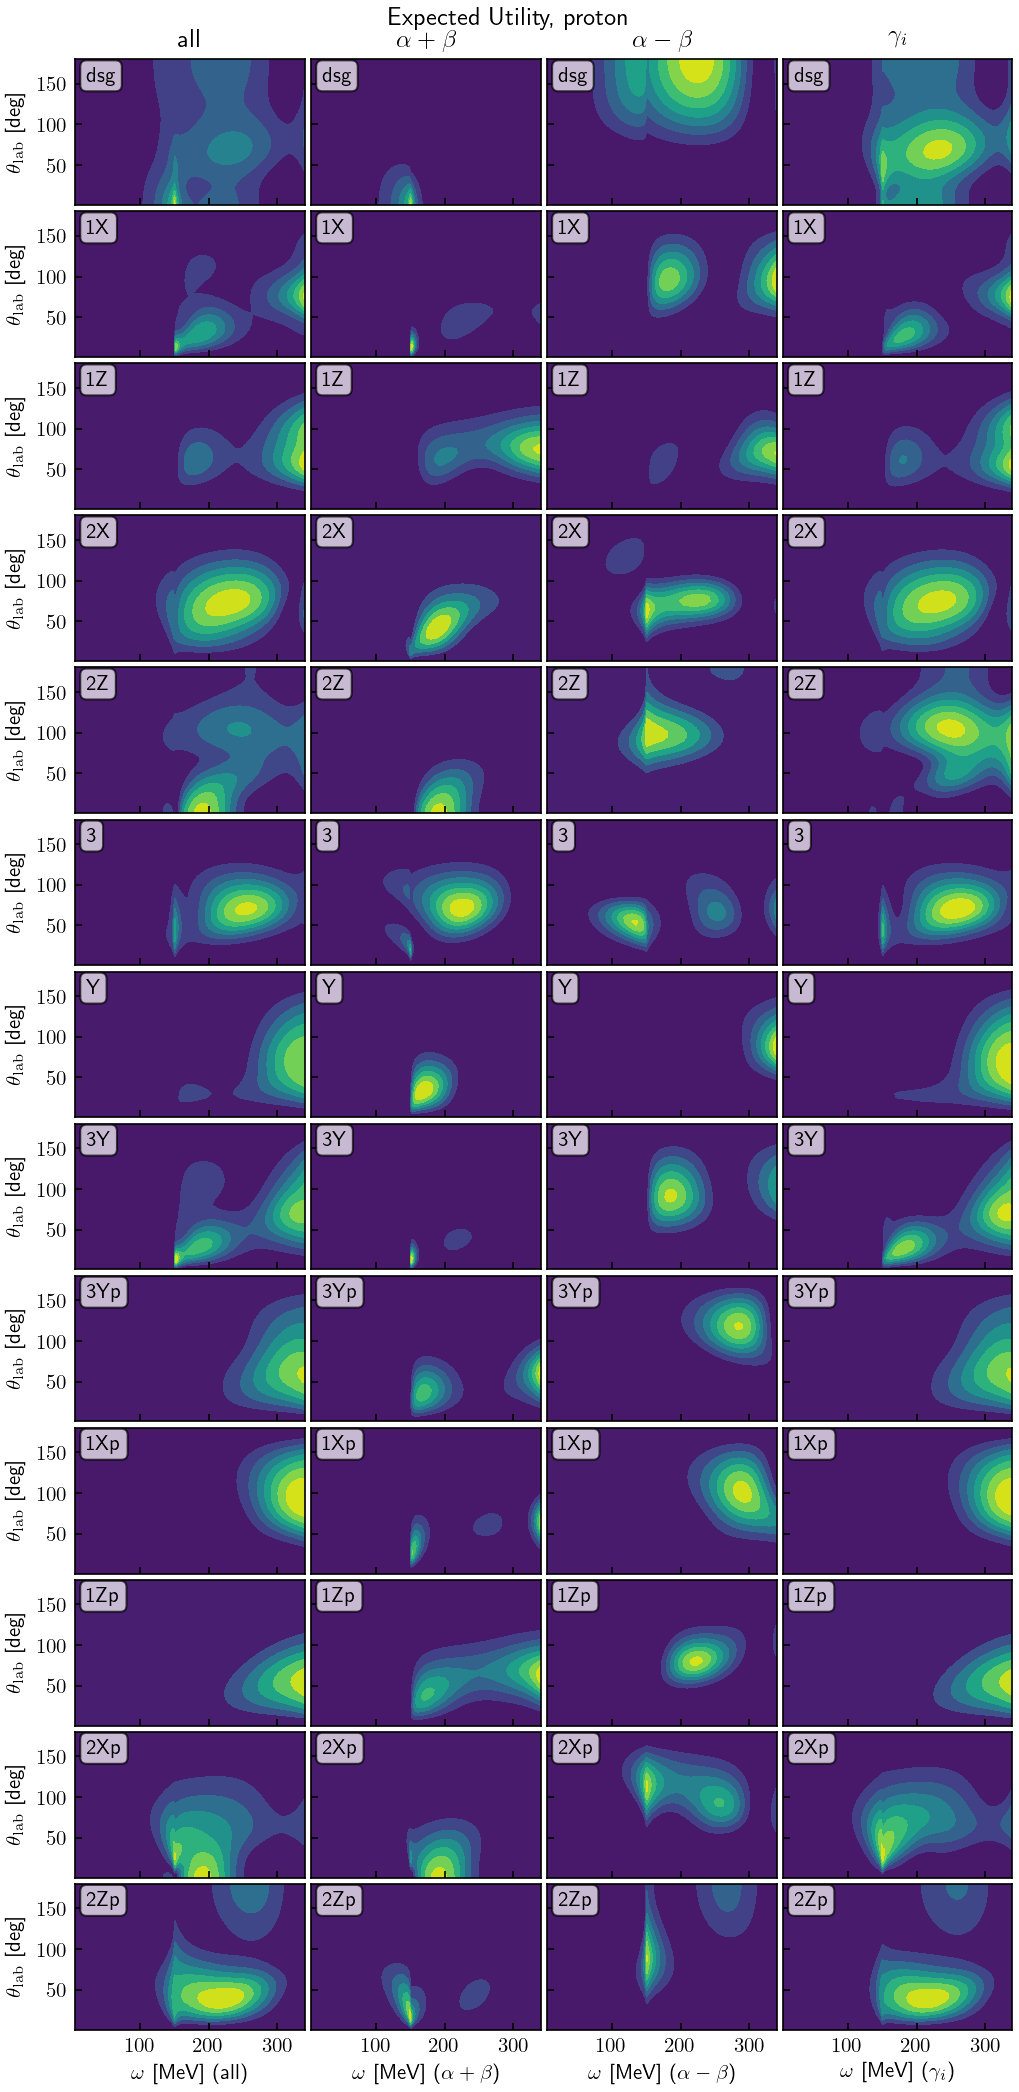

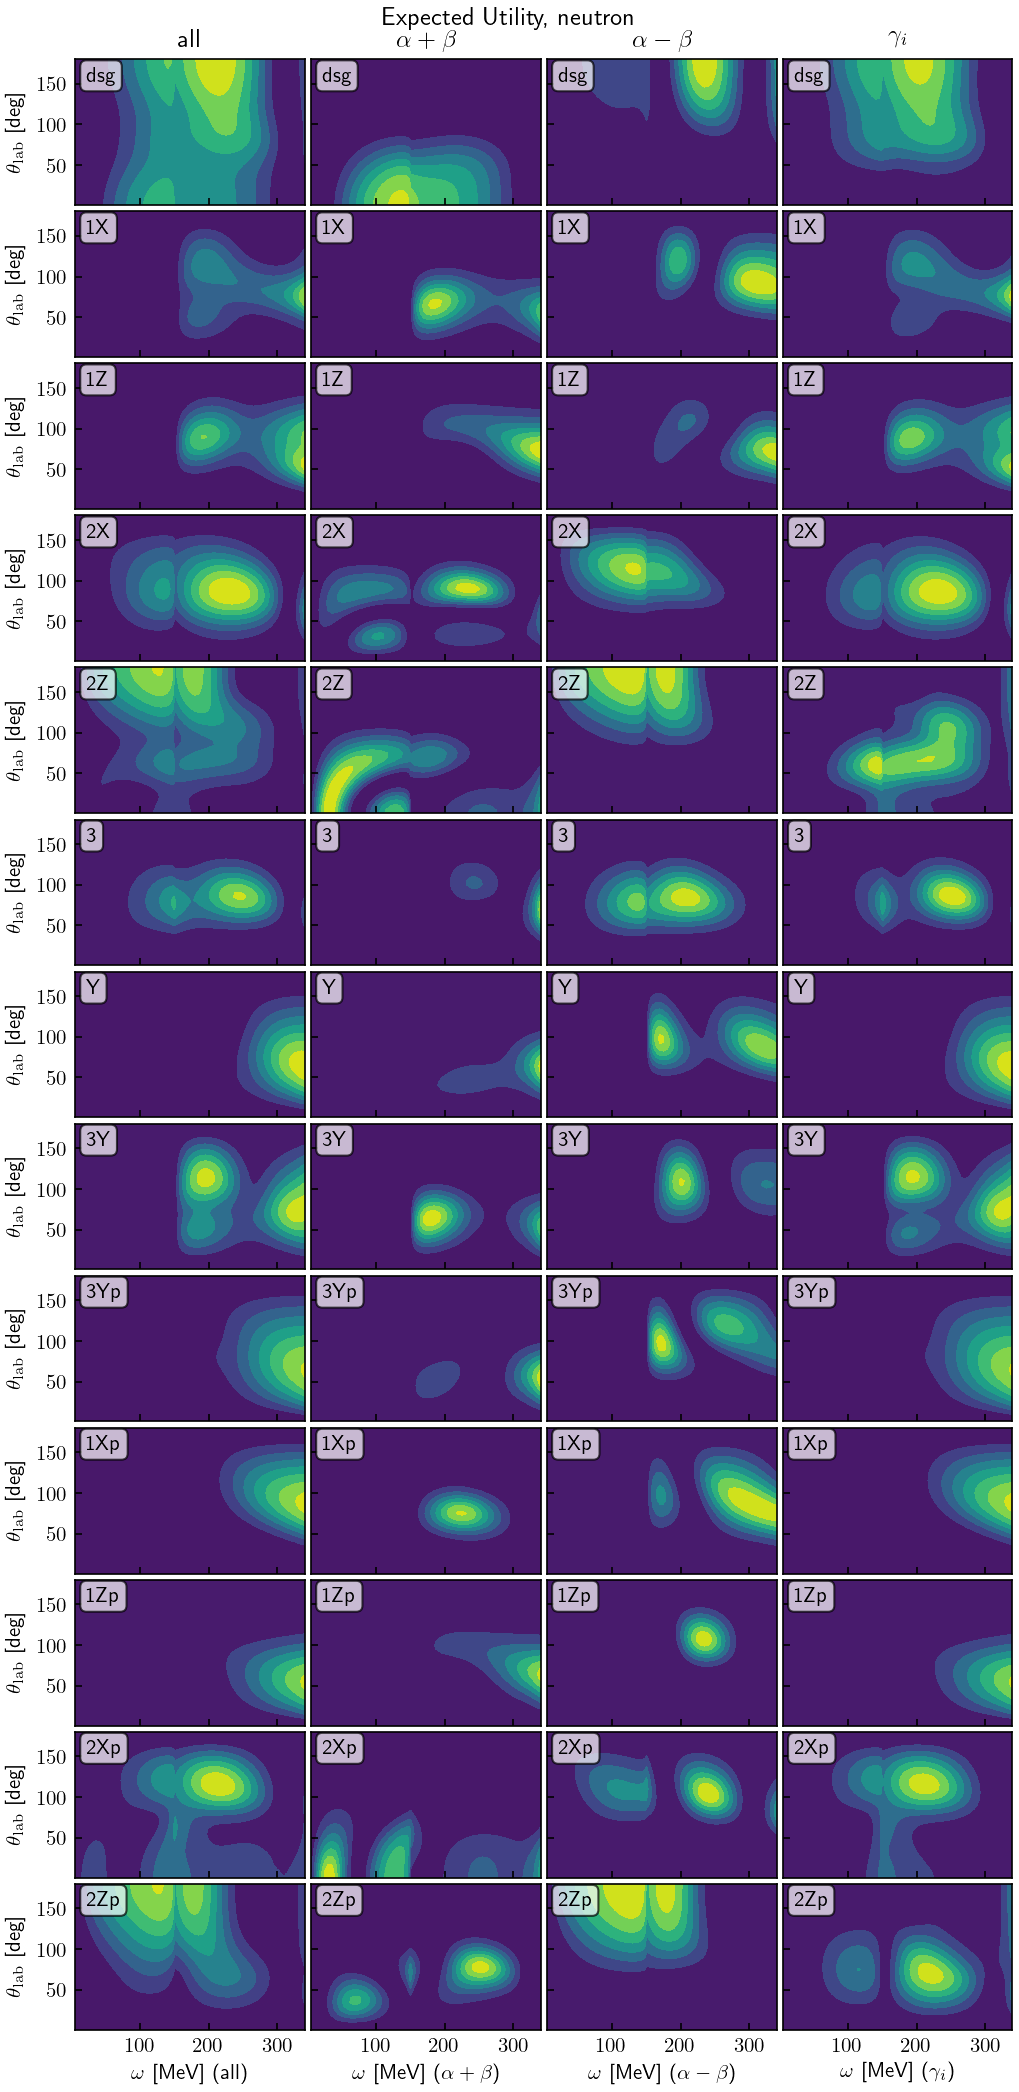

In [32]:
for nucleon in nucleons:
    fig, axes = plot_subsets(
        util_dict_trans_sets, nucleon, omega_lab_unique, degrees_lab_unique,
        observables=observables_unique, subsets=subset_names)
    fig.suptitle(f'Expected Utility, {nucleon}', y=1)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    plt.show()
    fig.savefig(f'figures/utility_{nucleon}_subsets_transformed.pdf')

## Truncation Error

In [33]:
util_dict_trans_trunc_sets = compute_all_1pt_utilities(compton_obs_trans_trunc, subsets)

In [34]:
bests_1pt_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_unique, degrees_lab_unique, n_degrees=1
)

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0
all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0


In [35]:
df_bests_1pt_trunc = convert_max_utilities_to_flat_dataframe(bests_1pt_trunc_dict)

In [36]:
df_bests_1pt_trunc

,idx,omega,theta,nucleon,observable,util,subset,shrinkage
0,185,30.0,1,neutron,2Xp,0.078604,$\alpha+\beta$,1.081776
1,185,30.0,1,neutron,2Z,0.078630,$\alpha+\beta$,1.081804
2,488,70.0,35,neutron,2Zp,0.010468,$\alpha+\beta$,1.010523
3,591,80.0,180,neutron,dsg,0.037774,$\alpha-\beta$,1.038497
4,628,85.0,180,neutron,2Z,0.425849,all,1.530889
...,...,...,...,...,...,...,...,...
99,2710,340.0,45,proton,1Zp,0.021666,$\gamma_i$,1.021902
100,2710,340.0,45,neutron,3Yp,0.029998,$\gamma_i$,1.030452
101,2710,340.0,45,neutron,1Zp,0.026089,all,1.026433
102,2710,340.0,45,neutron,1Zp,0.025710,$\gamma_i$,1.026044


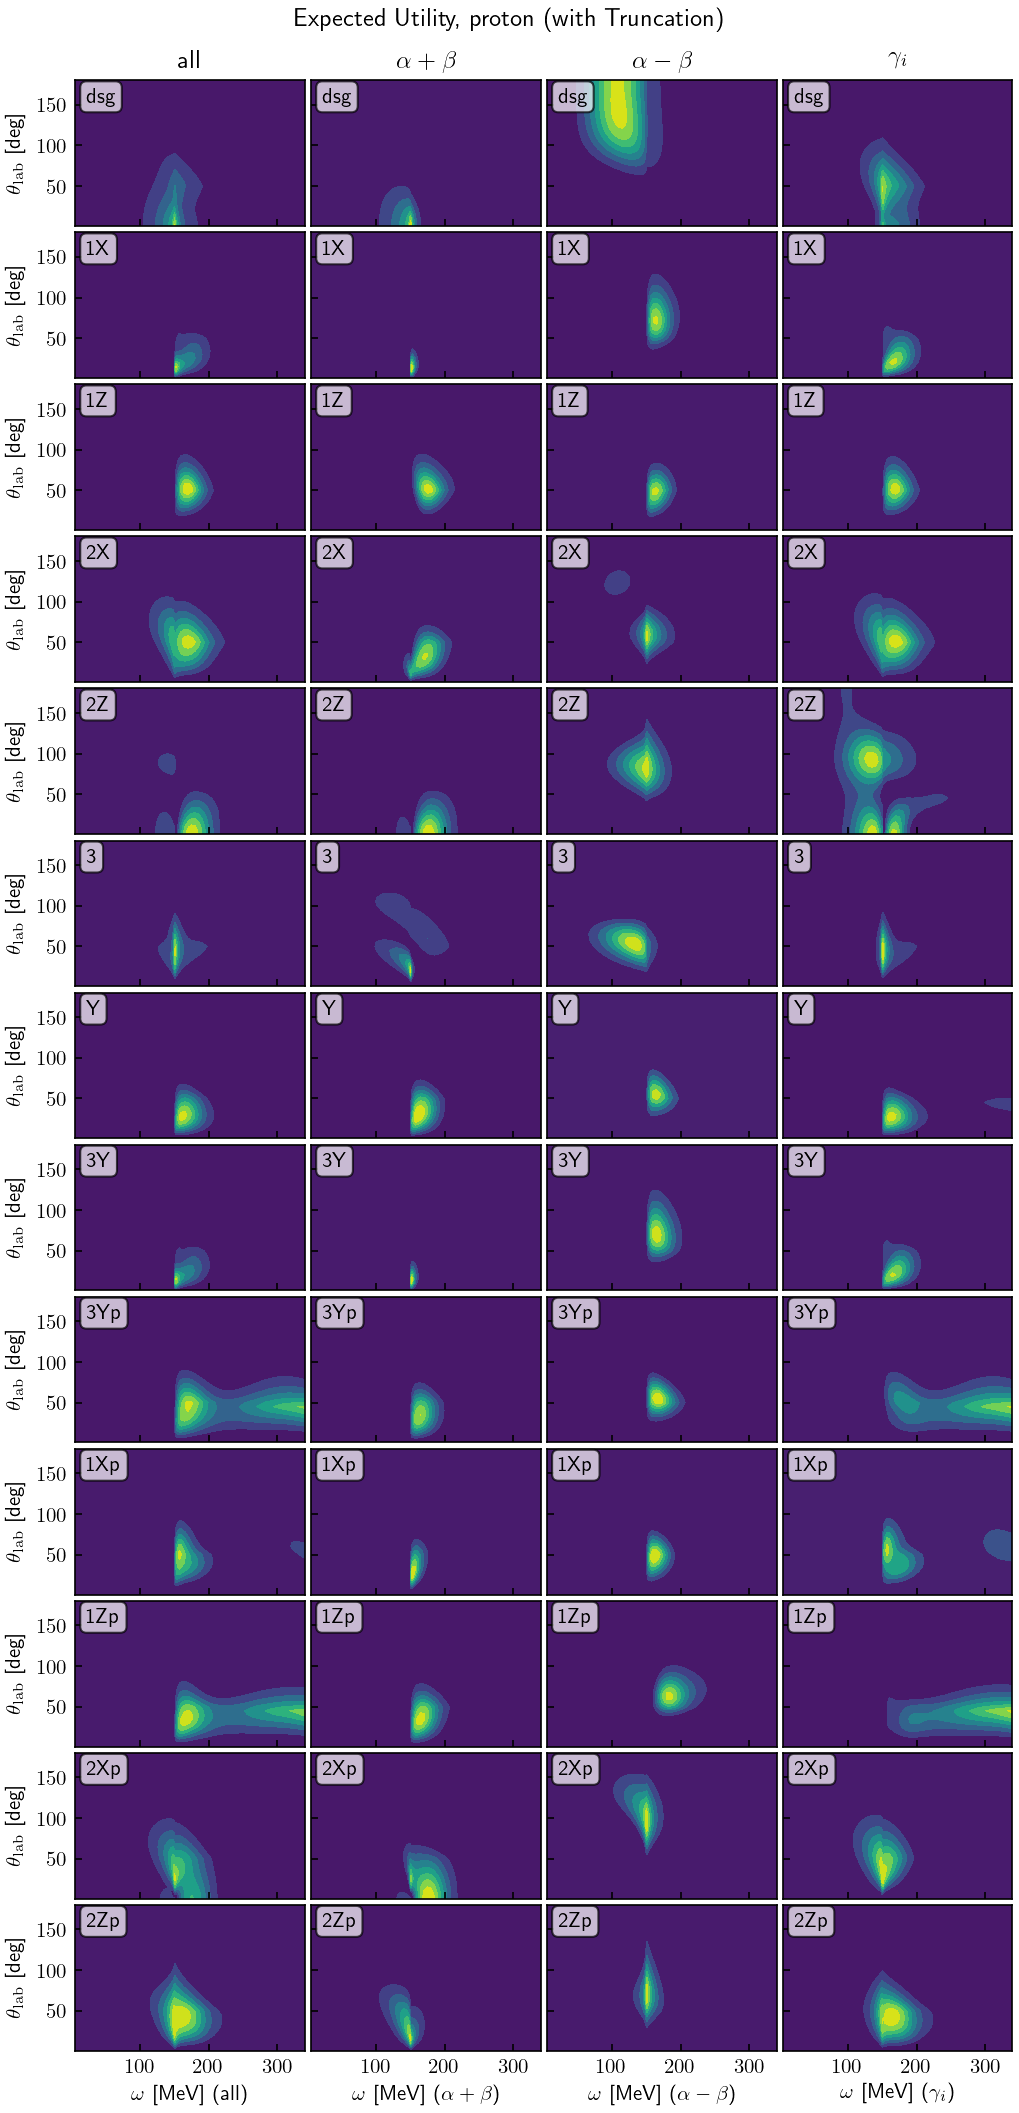

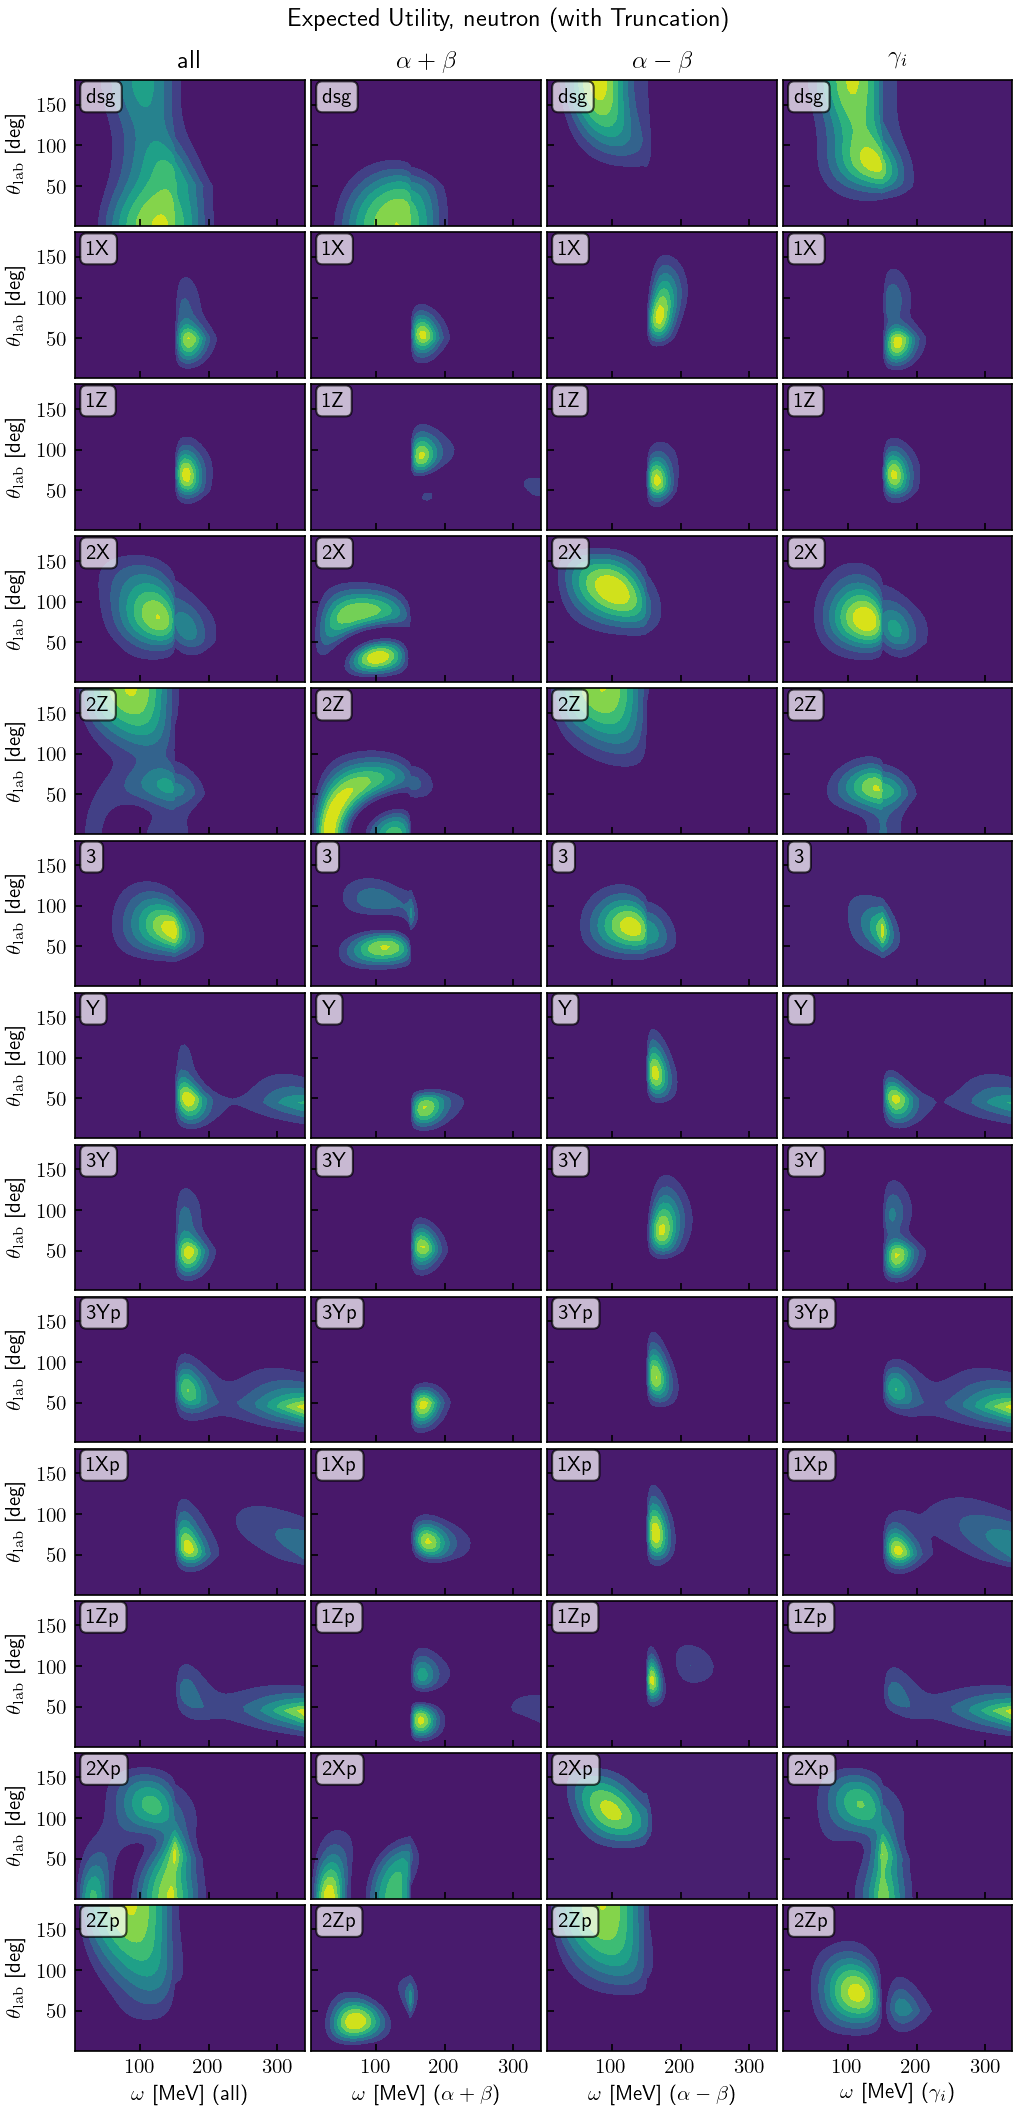

In [37]:
for nucleon in nucleons:
    fig, axes = plot_subsets(
        util_dict_trans_trunc_sets, nucleon, omega_lab_unique, degrees_lab_unique,
        observables=observables_unique, subsets=subset_names)
    fig.suptitle(f'Expected Utility, {nucleon} (with Truncation)', y=1.01)
    fig.tight_layout(h_pad=0.3, w_pad=0.3)
    plt.show()
    fig.savefig(f'figures/utility_{nucleon}_subsets_transformed_trunc.pdf')

In [38]:
# df_bests_1pt_trunc = pd.DataFrame.from_dict(util_dict_trans_trunc_sets_bests).T
# df_bests_1pt_trunc.index.names = 'observable', 'subset'
# df_bests_1pt_trunc = df_bests_1pt_trunc.reset_index()
# df_bests_1pt_trunc['idx'] = df_bests_1pt_trunc.astype({'idx': 'int32'})['idx']
# df_bests_1pt_trunc['shrinkage'] = np.exp(df_bests_1pt_trunc['util'])
# df_bests_1pt_trunc

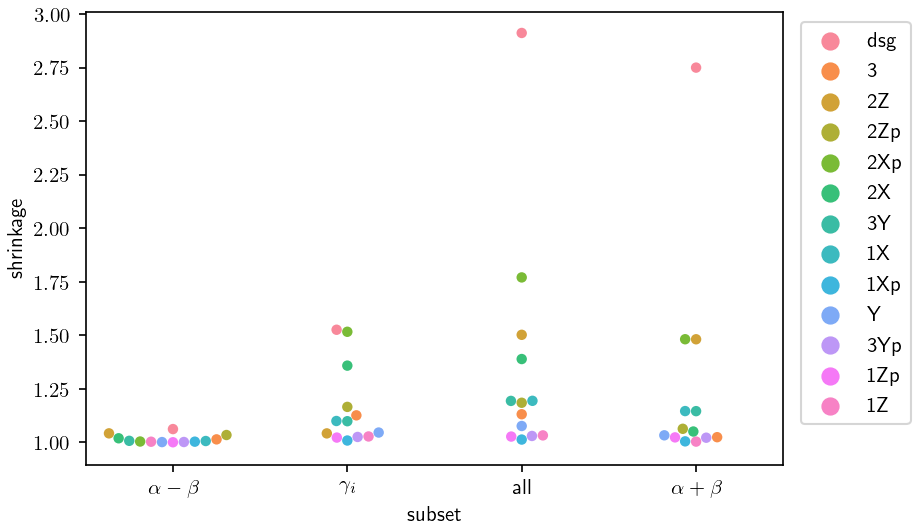

In [39]:
sns.swarmplot(
    x='subset', y='shrinkage', data=df_bests_1pt_trunc[df_bests_1pt_trunc['nucleon'] == 'proton'],
    hue='observable', #marker=list(df_bests_1pt_trunc['observable'].values)
)
plt.legend().set_bbox_to_anchor((1.01, 1))

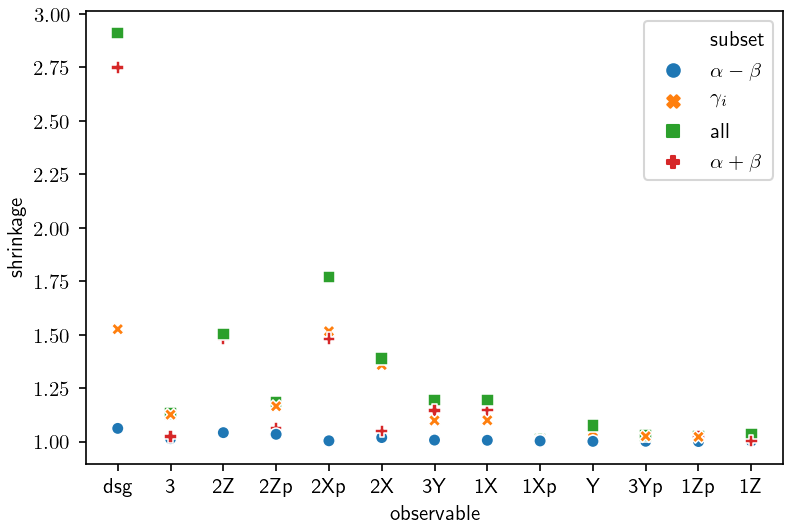

In [40]:
sns.scatterplot(
    x='observable', y='shrinkage', data=df_bests_1pt_trunc[df_bests_1pt_trunc['nucleon'] == 'proton'],
    hue='subset',
    style='subset'
)

In [41]:
util_dict_trans_trunc_sets

{('neutron',
  '1X',
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.12180915e-08, 9.17933340e-09, 0.00000000e+00]),
 ('proton',
  '1X',
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.15398748e-08, 1.38442222e-08, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\alpha+\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.03805853e-13, 1.38777878e-15, 0.00000000e+00]),
 ('proton',
  '1X',
  '$\\alpha+\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49102952e-13, 1.99840144e-15, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.40325307e-09, 7.39611469e-10, 0.00000000e+00]),
 ('proton',
  '1X',
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.12965342e-09, 1.55117868e-09, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\gamma_i$'): array([0.00000000e

In [42]:
/.

SyntaxError: invalid syntax (<ipython-input-42-8220ccc57e03>, line 1)

In [43]:
X_reduced = X[(X[:, 1] > 30) & (X[:, 1] < 150) & (X[:, 0] > 50)]
X_reduced = X_reduced[(X_reduced[:, 0] % 2 == 0) & (X_reduced[:, 1] % 2 == 0)]
omega_lab_reduced_unique = np.unique(X_reduced[:, 0])
degrees_lab_reduced_unique = np.unique(X_reduced[:, 1])

In [44]:
X_reduced

array([[ 60.,  40.],
       [ 60.,  50.],
       [ 60.,  60.],
       [ 60.,  70.],
       [ 60.,  80.],
       [ 60.,  90.],
       [ 60., 100.],
       [ 60., 110.],
       [ 60., 120.],
       [ 60., 130.],
       [ 60., 140.],
       [ 70.,  40.],
       [ 70.,  50.],
       [ 70.,  60.],
       [ 70.,  70.],
       [ 70.,  80.],
       [ 70.,  90.],
       [ 70., 100.],
       [ 70., 110.],
       [ 70., 120.],
       [ 70., 130.],
       [ 70., 140.],
       [ 80.,  40.],
       [ 80.,  50.],
       [ 80.,  60.],
       [ 80.,  70.],
       [ 80.,  80.],
       [ 80.,  90.],
       [ 80., 100.],
       [ 80., 110.],
       [ 80., 120.],
       [ 80., 130.],
       [ 80., 140.],
       [ 90.,  40.],
       [ 90.,  50.],
       [ 90.,  60.],
       [ 90.,  70.],
       [ 90.,  80.],
       [ 90.,  90.],
       [ 90., 100.],
       [ 90., 110.],
       [ 90., 120.],
       [ 90., 130.],
       [ 90., 140.],
       [100.,  40.],
       [100.,  50.],
       [100.,  60.],
       [100.,

In [45]:
len(X_reduced)

330

In [46]:
degrees_lab_reduced_unique

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [47]:
omega_lab_reduced_unique

array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 148., 152.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340.])

In [48]:
n_angle_search = 5

bests_npt_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=n_angle_search
)


# # best_util = -np.inf
# # best_idxs = None
# # best_obs = None
# # subset_name = 'all'
# # subset_name = r'$\alpha-\beta$'
# # subset = subsets[subset_name]

# util_bests_npts = {}



# for subset_name, subset in subsets.items():
#     bests = {obs: dict(util=-np.inf) for obs in observables_unique}
#     print(subset_name)
#     for aa, angles in enumerate(combinations(degrees_lab_reduced_unique, n_angle_search)):
#         if aa % 100 == 0:
#             print(aa)
#         for energy in omega_lab_reduced_unique:
#             for obs_i in observables_unique:
#     #             idxs = np.where((X_reduced[:, 0] == energy) & np.isin(X_reduced[:, 1], angles))[0]
#                 # The observable object is set up to only know about X
#                 idxs = np.where((X[:, 0] == energy) & np.isin(X[:, 1], angles))[0]
#                 order_i = 4
#                 compton_i = compton_obs_trans_trunc[obs_i, 'proton', order_i, 'linear']
#                 current_util = compton_i.utility_linear(idxs, p_idx=subset, only_log=False)
#                 if current_util > bests[obs_i]['util']:
#                     bests_i = bests[obs_i]
#                     bests_i['util'] = current_util
#                     bests_i['idxs'] = idxs
#                     bests_i['omega'] = X[idxs, 0]
#                     bests_i['theta'] = X[idxs, 1]
#                     util_bests_npts[obs_i, subset_name] = bests_i

# print(bests)
# print(util_bests_npts)
# # print(best_idxs)

all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400
all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400


In [66]:
df_bests_npt_trunc = convert_max_utilities_to_dataframe(bests_npt_trunc_dict)
df_bests_npt_trunc_flat = convert_max_utilities_to_flat_dataframe(bests_npt_trunc_dict)
df_bests_npt_trunc['n pts'] = n_angle_search

In [67]:
df_bests_npt_trunc

,nucleon,observable,subset,util,idxs,omega,theta,shrinkage,n pts
0,neutron,1X,all,0.177874,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.194675,5
1,neutron,1Xp,all,0.037078,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.037774,5
2,neutron,1Z,all,0.110601,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.116949,5
3,neutron,1Zp,all,0.062763,"[2709, 2711, 2713, 2715, 2717]","[340.0, 340.0, 340.0, 340.0, 340.0]","[40, 50, 60, 70, 80]",1.064775,5
4,neutron,2X,all,0.862183,"[865, 867, 869, 871, 873]","[120.0, 120.0, 120.0, 120.0, 120.0]","[70, 80, 90, 100, 110]",2.368324,5
...,...,...,...,...,...,...,...,...,...
99,proton,3,$\gamma_i$,0.294162,"[1266, 1268, 1270, 1272, 1274]","[152.0, 152.0, 152.0, 152.0, 152.0]","[40, 50, 60, 70, 80]",1.342001,5
100,proton,3Y,$\gamma_i$,0.091644,"[1525, 1527, 1529, 1531, 1537]","[180.0, 180.0, 180.0, 180.0, 180.0]","[40, 50, 60, 70, 100]",1.095975,5
101,proton,3Yp,$\gamma_i$,0.062254,"[2635, 2637, 2639, 2641, 2643]","[330.0, 330.0, 330.0, 330.0, 330.0]","[40, 50, 60, 70, 80]",1.064233,5
102,proton,Y,$\gamma_i$,0.061992,"[1377, 1379, 1381, 1383, 1385]","[160.0, 160.0, 160.0, 160.0, 160.0]","[40, 50, 60, 70, 80]",1.063953,5


In [68]:
bests_1pt_reduced_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=1
)
df_bests_1pt_reduced_trunc = convert_max_utilities_to_dataframe(bests_1pt_reduced_trunc_dict)
df_bests_1pt_reduced_trunc_flat = convert_max_utilities_to_flat_dataframe(bests_1pt_reduced_trunc_dict)
df_bests_1pt_reduced_trunc['n pts'] = 1

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0
all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0


In [50]:
# bests_npts = pd.DataFrame.from_dict(util_bests_npts).T
# bests_npts.index.names = 'observable', 'subset'
# bests_npts = bests_npts.reset_index()
# # bests_npts['idx'] = bests_npts.astype({'idx': 'int32'})['idx']
# bests_npts['util'] = bests_npts.astype({'util': 'float64'})['util']
# bests_npts['shrinkage'] = np.exp(bests_npts['util'])
# bests_npts

In [51]:
# bests_df = pd.DataFrame.from_dict(bests).T
# bests_df.index.name = 'observable'
# bests_df = bests_df.reset_index()
# bests_df['subset'] = subset_name

In [52]:
# bests_df

In [53]:
# bests_df.max()

In [54]:
# idxs_flat = []
# omega_flat = []
# theta_flat = []
# obs_flat = []
# subset_flat = []
# util_flat = []

# for (obs, subset), best in util_bests_npts.items():
#     idxs_flat = idxs_flat + list(best['idxs'])
#     omega_flat = omega_flat + list(best['omega'])
#     theta_flat = theta_flat + list(best['theta'])
#     obs_flat = obs_flat + [obs for i in range(len(best['idxs']))]
#     subset_flat = subset_flat + [subset for i in range(len(best['idxs']))]
#     util_flat = util_flat + [best['util'] for i in range(len(best['idxs']))]
    
# bests_df_flat = pd.DataFrame(
#     {'idx': idxs_flat, 'omega': omega_flat, 'theta': theta_flat,
#      'observable': obs_flat, 'util': util_flat, 'subset': subset_flat}
# )

In [55]:
df_bests_npt_trunc_flat

,idx,omega,theta,nucleon,observable,util,subset,shrinkage
0,415,60.0,40,neutron,2Z,0.242917,$\alpha+\beta$,1.274962
1,417,60.0,50,neutron,2Z,0.242917,$\alpha+\beta$,1.274962
2,419,60.0,60,neutron,2Z,0.242917,$\alpha+\beta$,1.274962
3,421,60.0,70,neutron,2Z,0.242917,$\alpha+\beta$,1.274962
4,423,60.0,80,neutron,2Z,0.242917,$\alpha+\beta$,1.274962
...,...,...,...,...,...,...,...,...
515,2715,340.0,70,neutron,1Zp,0.062763,all,1.064775
516,2717,340.0,80,neutron,3Yp,0.079760,$\gamma_i$,1.083027
517,2717,340.0,80,neutron,1Zp,0.061752,$\gamma_i$,1.063698
518,2717,340.0,80,neutron,1Zp,0.062763,all,1.064775


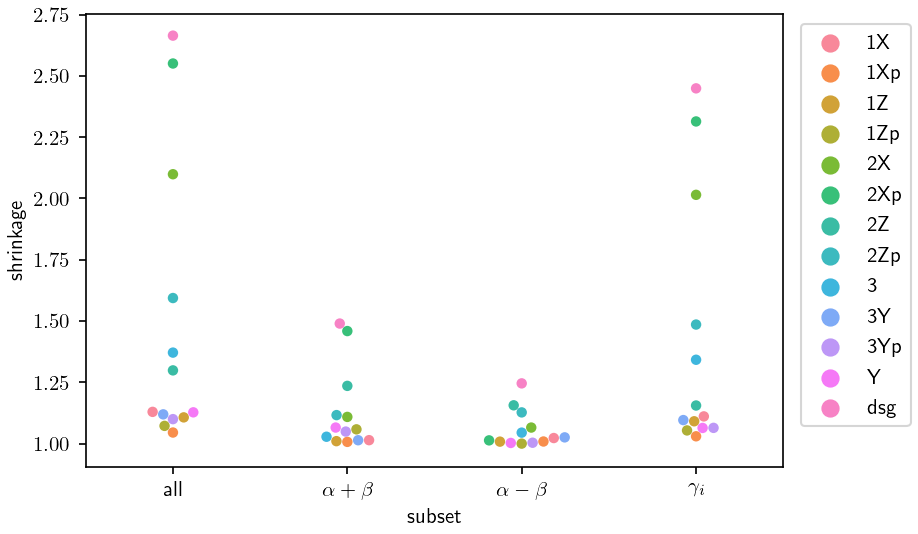

In [57]:
sns.swarmplot(
    x='subset', y='shrinkage', data=df_bests_npt_trunc[df_bests_npt_trunc['nucleon'] == 'proton'],
    hue='observable')
plt.legend().set_bbox_to_anchor((1.01, 1))

In [78]:
df_bests_join = pd.concat([df_bests_npt_trunc, df_bests_1pt_reduced_trunc], sort=False)
df_bests_join

,nucleon,observable,subset,util,idxs,omega,theta,shrinkage,n pts
0,neutron,1X,all,0.177874,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.194675,5
1,neutron,1Xp,all,0.037078,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.037774,5
2,neutron,1Z,all,0.110601,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.116949,5
3,neutron,1Zp,all,0.062763,"[2709, 2711, 2713, 2715, 2717]","[340.0, 340.0, 340.0, 340.0, 340.0]","[40, 50, 60, 70, 80]",1.064775,5
4,neutron,2X,all,0.862183,"[865, 867, 869, 871, 873]","[120.0, 120.0, 120.0, 120.0, 120.0]","[70, 80, 90, 100, 110]",2.368324,5
...,...,...,...,...,...,...,...,...,...
99,proton,3,$\gamma_i$,0.101993,[1268],[152.0],[50],1.107375,1
100,proton,3Y,$\gamma_i$,0.051990,[1525],[180.0],[40],1.053365,1
101,proton,3Yp,$\gamma_i$,0.022620,[2709],[340.0],[40],1.022878,1
102,proton,Y,$\gamma_i$,0.033074,[1377],[160.0],[40],1.033627,1


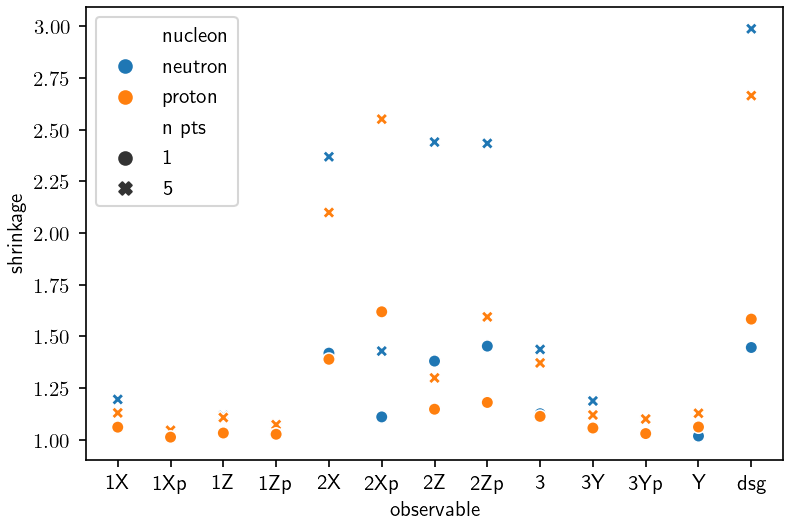

In [87]:
sns.scatterplot(
    x='observable', y='shrinkage', data=df_bests_join[df_bests_join['subset'] == 'all'],
    hue='nucleon', style='n pts'
)
# plt.legend().set_bbox_to_anchor((1.01, 1))

In [90]:
from compton.graphs import plot_utilities_all_observables

In [93]:
util_dict_trans_trunc_sets

{('neutron',
  '1X',
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.12180915e-08, 9.17933340e-09, 0.00000000e+00]),
 ('proton',
  '1X',
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.15398748e-08, 1.38442222e-08, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\alpha+\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.03805853e-13, 1.38777878e-15, 0.00000000e+00]),
 ('proton',
  '1X',
  '$\\alpha+\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49102952e-13, 1.99840144e-15, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.40325307e-09, 7.39611469e-10, 0.00000000e+00]),
 ('proton',
  '1X',
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.12965342e-09, 1.55117868e-09, 0.00000000e+00]),
 ('neutron',
  '1X',
  '$\\gamma_i$'): array([0.00000000e

In [95]:
bests_npt_trunc_dict

{('neutron', '1X', 'all'): {'util': 0.17787378308748847,
  'idxs': array([1451, 1453, 1455, 1457, 1459]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([40, 50, 60, 70, 80])},
 ('neutron', '1Xp', 'all'): {'util': 0.03707812097870922,
  'idxs': array([1453, 1455, 1457, 1459, 1461]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([50, 60, 70, 80, 90])},
 ('neutron', '1Z', 'all'): {'util': 0.1106006632687424,
  'idxs': array([1453, 1455, 1457, 1459, 1461]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([50, 60, 70, 80, 90])},
 ('neutron', '1Zp', 'all'): {'util': 0.06276343791424521,
  'idxs': array([2709, 2711, 2713, 2715, 2717]),
  'omega': array([340., 340., 340., 340., 340.]),
  'theta': array([40, 50, 60, 70, 80])},
 ('neutron', '2X', 'all'): {'util': 0.8621825714241657,
  'idxs': array([865, 867, 869, 871, 873]),
  'omega': array([120., 120., 120., 120., 120.]),
  'theta': array([ 70,  80,  90, 100, 110])},
 ('neutron', '2

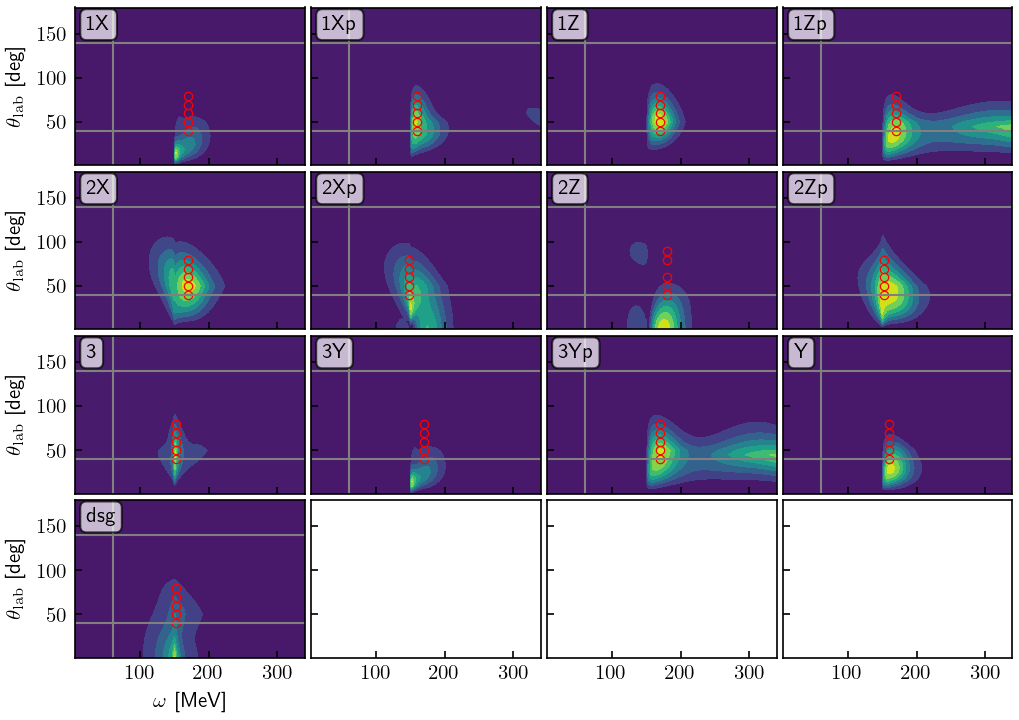

In [113]:
fig, axes = plot_utilities_all_observables(
    util_dict_trans_trunc_sets, 'proton', 'all',
    omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
    xgrid=[np.min(omega_lab_reduced_unique)],
    ygrid=[np.min(degrees_lab_reduced_unique), np.max(degrees_lab_reduced_unique)]
)

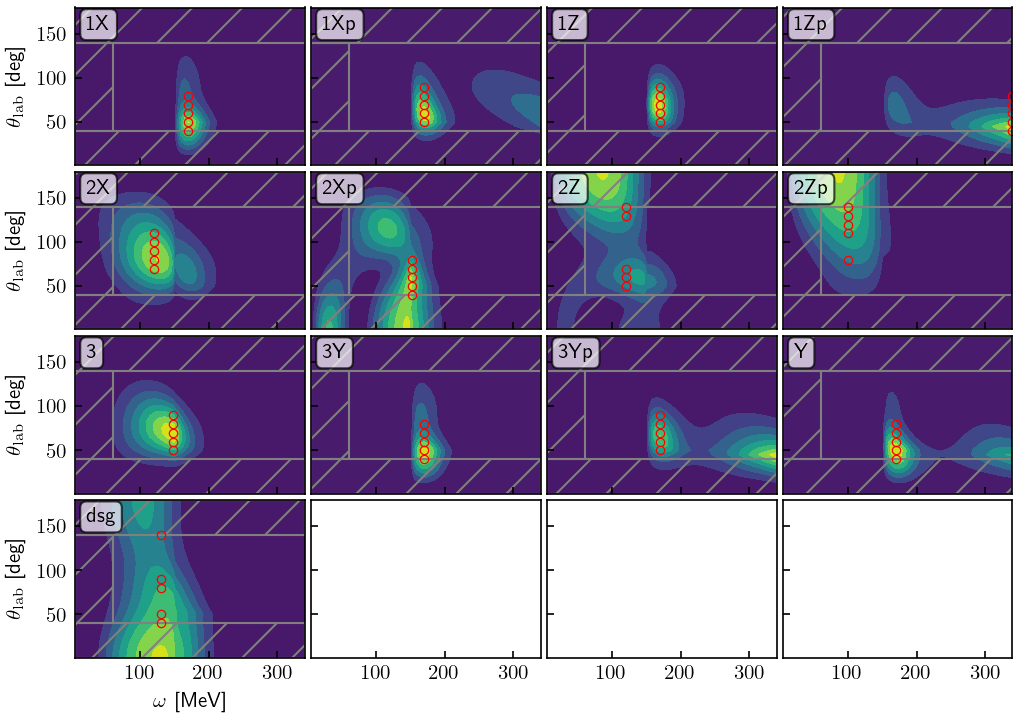

In [122]:
fig, axes = plot_utilities_all_observables(
    util_dict_trans_trunc_sets, 'neutron', 'all',
    omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
#     xgrid=[np.min(omega_lab_reduced_unique)],
#     ygrid=[np.min(degrees_lab_reduced_unique), np.max(degrees_lab_reduced_unique)]
    degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
    omega_min=np.min(omega_lab_reduced_unique),
)

In [ ]:
plt.fill_between()

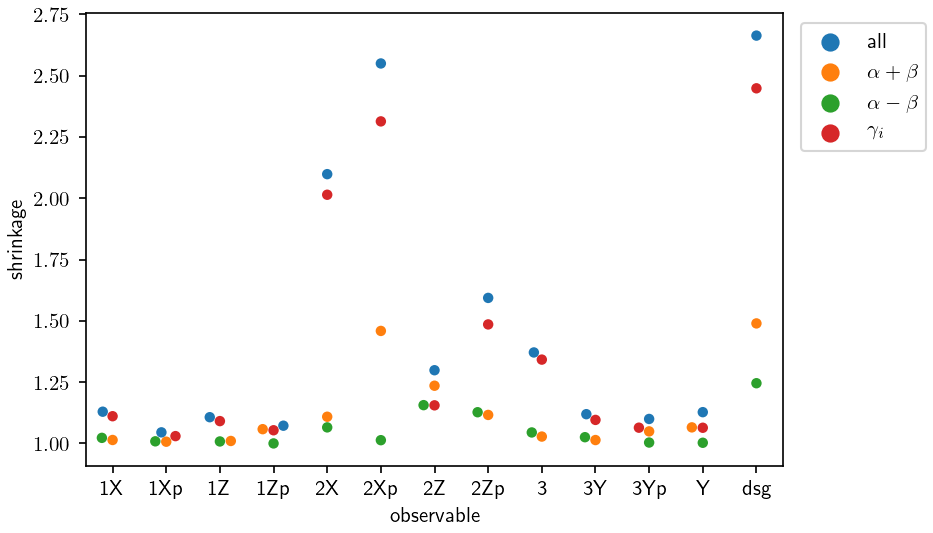

In [62]:
sns.swarmplot(
    x='observable', y='shrinkage', data=df_bests_npt_trunc[df_bests_npt_trunc['nucleon'] == 'proton'],
    hue='subset'
)
plt.legend().set_bbox_to_anchor((1.01, 1))

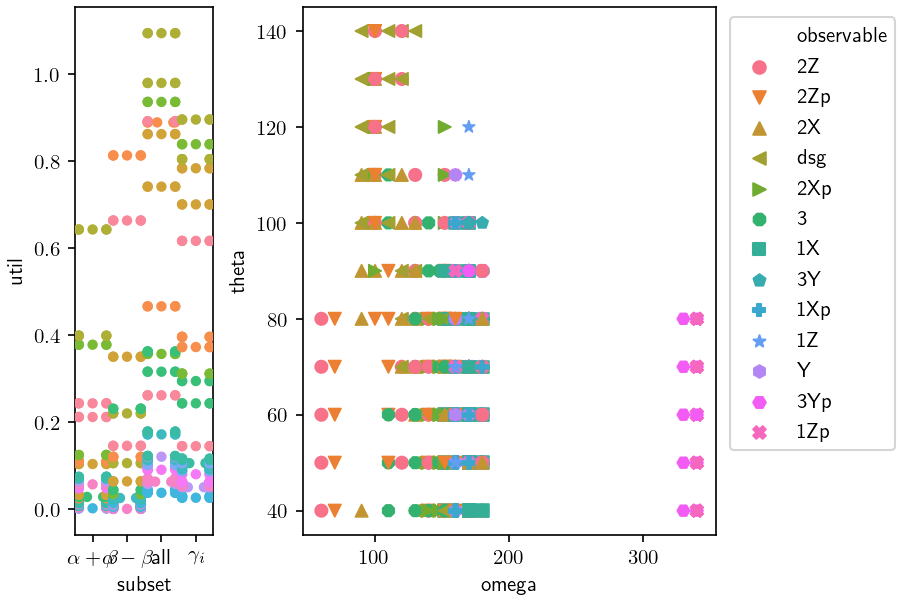

In [61]:
markers2 = ['o', 'v', '^', '<', '>', '8', 's', 'p', 'P', '*', 'h', 'H', 'X']

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig = plt.figure(constrained_layout=True)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs1[0, 1:])
ax2 = fig.add_subplot(gs1[0, 0])

sns.scatterplot(x='omega', y='theta', data=df_bests_npt_trunc_flat, hue='observable', style='observable',
                markers=markers2, facecolor='white', edgecolor=None, ax=ax1)
sns.swarmplot(x='subset', y='util', data=df_bests_npt_trunc_flat, hue='observable', ax=ax2)

# ax1.set_title(fr'Grid Locations ($\xi =$ {subset_name})')
ax2.legend().remove()
ax1.legend().set_bbox_to_anchor((1.01, 1))
# fig.savefig(f'figures/grids_and_utilities_trunc_subset-{subset_savenames[subset_name]}.pdf')

In [ ]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '1', '2', '3', '4', 'P', '*']

In [ ]:
plot_kwargs = {
    'crosssection': dict(fillstyle='none', marker='o'),
}

In [ ]:
fig, ax = plt.subplots()
# ax.plot(X_reduced[:, 0], X_reduced[:, 1], ls='', marker=',', c='k')
for i, obs in enumerate(bests):
    ax.plot(bests[obs]['omega'], bests[obs]['theta'], ls='', marker=markers[i], fillstyle='none', label=obs)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

In [ ]:
X_reduced[best_idxs]